In [138]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import scipy as sp
import scipy.sparse.linalg
import time
from scipy import interpolate

plt.rcParams["figure.figsize"] = (8,8)

from RHS_for_v import *

plt.rcParams.update({'font.size': 22})

Implementation of the solution splitting technique with cylindrical symmetry around the vessel:

$$-D \Delta \phi = - \delta_\Lambda q$$

$$\phi \mathbf(x)=0 \quad on \quad \partial \Omega_{ext}$$
$$\nabla_n \phi\mathbf(x)=0 \quad on \quad \partial \Omega_{east, west}$$

$$\iiint_\Omega \delta_\Lambda f\mathbf(x) dV = \int_\Lambda f(s)ds$$

$$\phi= \phi_s + \phi_r$$

$\phi$ represents the scalar field that we want to recover 

$$\phi_s=G(r)q(s)$$

with: $G(r)=-\frac{1}{2 \pi D}log(\frac{r}{R_v})$


$$\Delta \phi = \Delta (G(r)q(s)) + \Delta \phi_r$$
$$-\delta_\Lambda \frac{q}{D} = (\Delta G(r))q(s) + 2\nabla G \cdot \nabla q + Gq"(s) +  \Delta \phi_r$$


For this particular problem we have:
$$\Delta \phi_r = -G(r)\frac{d^2 q}{d s^2}$$

with the following boundary conditions:

$$\frac{\partial \phi_r}{\partial s}= - G(r)\frac{\partial q(s)}{\partial s} \quad  on \quad \partial \Omega_{east,west}$$

$$\phi_r(R_{max}, s) = -G(R_{max})q(s) \quad on \quad \partial \Omega_{ext}$$



For the internal boundary conditions (near the vessel wall:

$$\nabla \phi \cdot \mathbf{n} = - \frac{q(s)}{2 \pi R_v}$$
in this case $\mathbf{n}= - \mathbf{e}_r$ 

Therefore:
$$\frac{\partial \phi}{\partial r}= \frac{q(s)}{2 \pi R_v} \quad on \quad \Omega_{in}$$

Further:
$$\nabla(G(r)q(s))\cdot (-\mathbf{e_r})=\frac{q(s)}{2 \pi R_v}$$

Therefore:
$$\frac{\partial \phi_r}{\partial r}= 0 \quad on \quad \Omega_{in}$$


We obtain the full problem:
\begin{cases}
\Delta \phi_r = -G(r)\dfrac{d^2 q}{d s^2} \\
\\
  \dfrac{\partial \phi_r}{\partial s}= - G(r)\dfrac{\partial q(s)}{\partial s} \quad  on \quad \partial \Omega_{east,west} \\
  \\
  \phi_r(R_{max}, s) = -G(R_{max})q(s) \quad on \quad \partial \Omega_{ext} \\
  \\
  \dfrac{\partial \phi}{\partial r}= 0 \quad on \quad \Omega_{in} \\
\end{cases}  



In [139]:
from importlib import reload

R_max=1
L=1
s_points=100
r_points=100
Rv=0.05
D=1
K_eff=5
inner_modification=False
my_west_mode=True
sour="cosine"

In [140]:
obj_fine=simplified_assembly_Laplacian_cylindrical(R_max, Rv,r_points,s_points, L, D)
f_hs, f_hr=obj_fine.inc_s, obj_fine.inc_r
Lap_operator=obj_fine.assembly().toarray()

f_r=obj_fine.r
f_s=obj_fine.s

In [141]:
if sour=="cosine":
    #Set an analytical source profile
    q_vessel=np.cos(obj_fine.s/(L*0.7))
    q_first=-(1/(L*0.7))*np.sin(obj_fine.s/(L*0.7))
    q_sec=-np.cos(obj_fine.s/(L*0.7))*(1/(L*0.7))**2
if sour=="constant":
    q_vessel=np.zeros(len(obj_fine.s))+1
    q_first=q_vessel-1
    q_sec=q_vessel-1

In [142]:
der1=get_first_der(q_vessel, f_hs).dot(q_vessel)
der2=get_sec_der(q_vessel, f_hs).dot(q_vessel)

/home/pdavid/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [143]:
#Set Dirichlet on the outer boundary
ext_boundary=np.concatenate([[obj_fine.corners[2]], obj_fine.outer_boundary, [obj_fine.corners[3]]])
Lap_operator[obj_fine.outer_boundary,:]=0
Lap_operator[obj_fine.outer_boundary,obj_fine.outer_boundary]=1

In [144]:
sing_sing_fine=np.outer(Green(obj_fine.r, Rv), q_vessel)
sol_real_fine=get_RHS_validation(Lap_operator,q_vessel, Rv, obj_fine.inc_r,obj_fine.inc_s, D, ext_boundary)
v_real_fine=sol_real_fine-sing_sing_fine
rhs_real_fine=Lap_operator.dot(np.ndarray.flatten(v_real_fine))
RHS_real_fine=rhs_real_fine.reshape(len(f_r), len(f_r))

302.6684641753415


(<matplotlib.contour.QuadContourSet at 0x7f91804f8520>,
 <matplotlib.colorbar.Colorbar at 0x7f918042a8e0>)

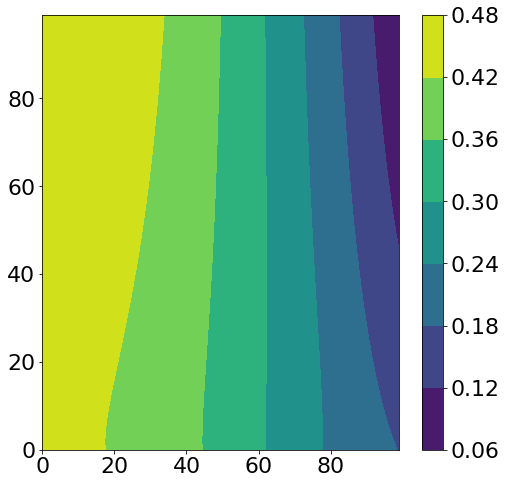

In [145]:
plt.contourf(v_real_fine), plt.colorbar()

In [146]:
rhs_split_fine=get_RHS(q_vessel,D, Rv, obj_fine.s, obj_fine.r, obj_fine.inc_s, obj_fine.inc_r,  obj_fine.east_boundary, obj_fine.west_boundary, obj_fine.outer_boundary, obj_fine.corners, q_first, q_sec)
RHS_split_fine=rhs_split_fine.reshape(len(obj_fine.r), len(obj_fine.s))

In [147]:
if my_west_mode:
    print("\n My west mode on \n")
    RHS_split_fine[1:-1,-1]*=-(1/f_hs)
    rhs_split_fine=np.ndarray.flatten(RHS_split_fine)
if inner_modification:
    print("\ninner mode ON\n")
    RHS_split_fine[0,1:-1]=RHS_real_fine[0,1:-1]
    rhs_split_fine=np.ndarray.flatten(RHS)


 My west mode on 



In [148]:
v_split_fine=sp.sparse.linalg.spsolve(Lap_operator, rhs_split_fine).reshape(len(f_r), len(f_s))
sol_split_fine=v_split_fine+sing_sing_fine

/home/pdavid/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Text(0, 0.5, 'v')

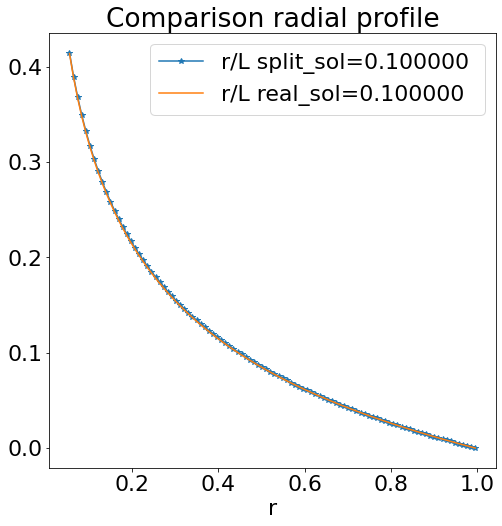

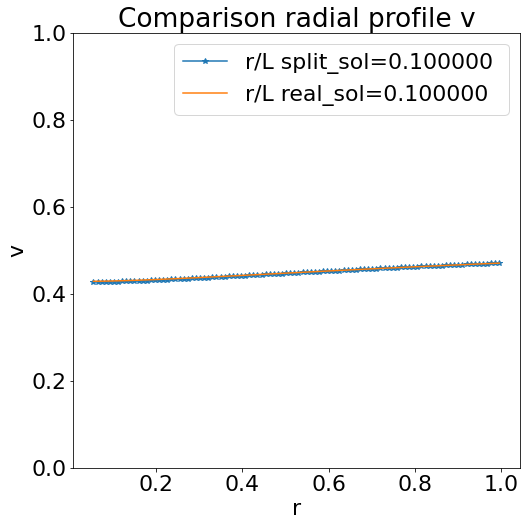

In [149]:
plt.figure()
plot_profile(1,f_s, f_r, sol_split_fine, sol_real_fine, "Comparison radial profile")
plt.figure()
plot_profile(1, f_s, f_r, v_real_fine, v_split_fine, "Comparison radial profile v")
plt.ylim([0,1])
plt.ylabel("v")

Text(0, 0.5, '$\\phi$')

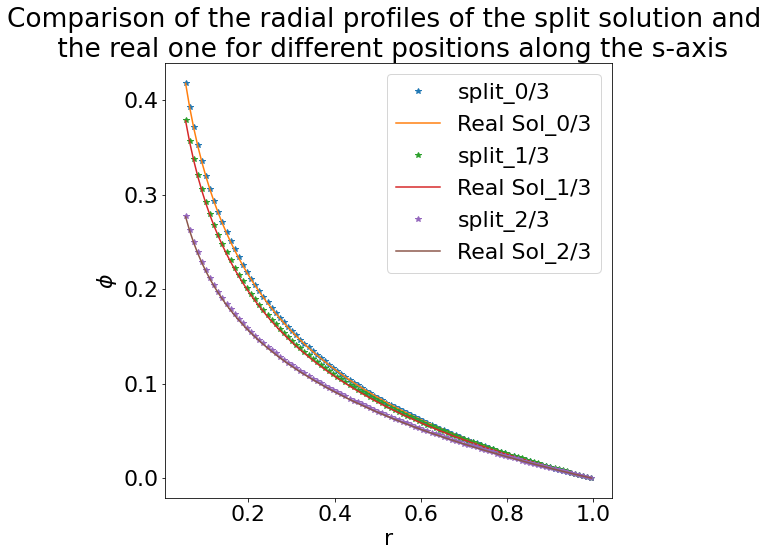

In [150]:
N=3
plt.figure()
for i in range(N):
    l=len(f_s)//N
    pos=l*i
    plt.plot(f_r, sol_split_fine[:,pos], '*', label='split_{}/3'.format(i))
    #plt.plot(k.r, analyt)
    plt.plot(f_r, sol_real_fine[:,pos], label='Real Sol_{}/3'.format(i))
    # =============================================================================
    # plt.plot(k.r, v_real_fine[:,10])
    # plt.plot(k.r, sol[:,10])
    # =============================================================================
plt.legend()
plt.title("Comparison of the radial profiles of the split solution and \n the real one for different positions along the s-axis")
plt.xlabel("r")
plt.ylabel("$\phi$")

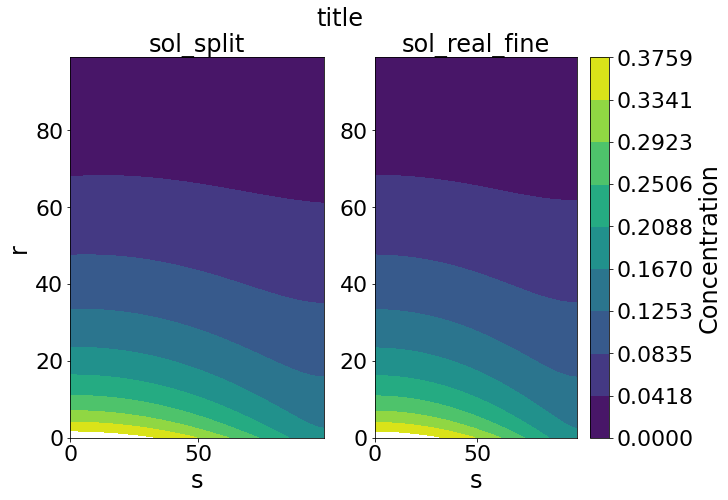

In [151]:
compare_full_solutions(sol_split_fine, sol_real_fine, "sol_split", "sol_real_fine", [0,np.max(sol_real_fine)], "title")

In [152]:
rhs_sing_fine=Lap_operator.dot(np.ndarray.flatten(sing_sing_fine))
RHS_sing_fine=rhs_sing_fine.reshape(len(f_r), len(f_s))

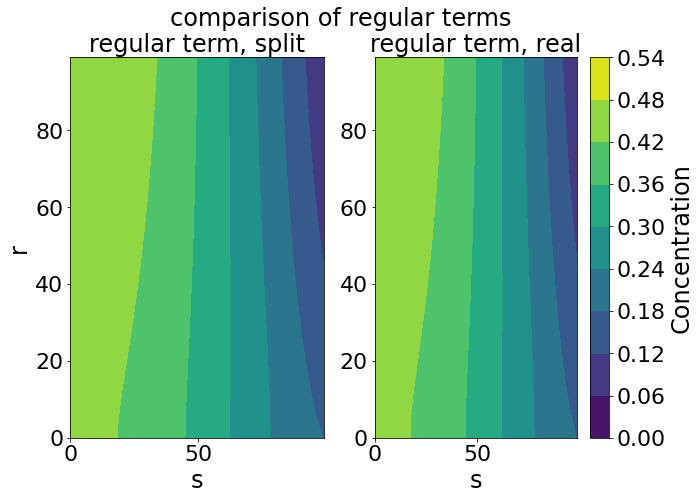

In [153]:
compare_full_solutions(v_split_fine, v_real_fine, "regular term, split", "regular term, real", [0,0.6],"comparison of regular terms")

hs/V_cell=302.6684641753415


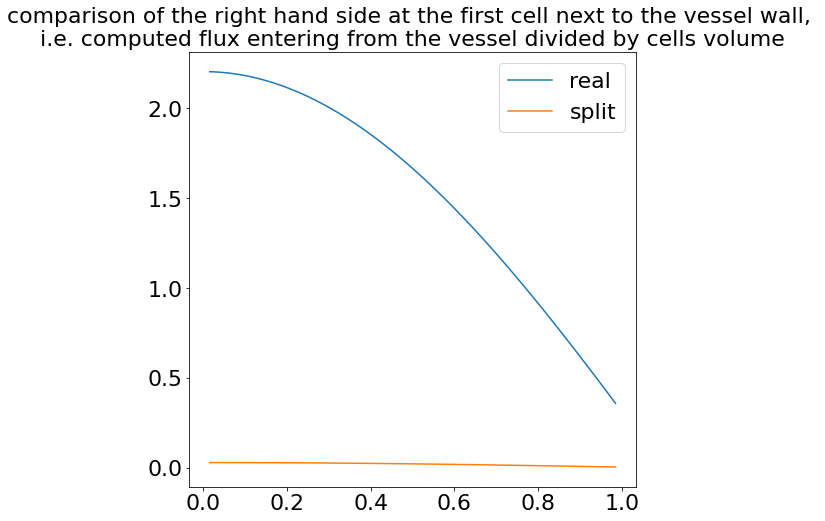

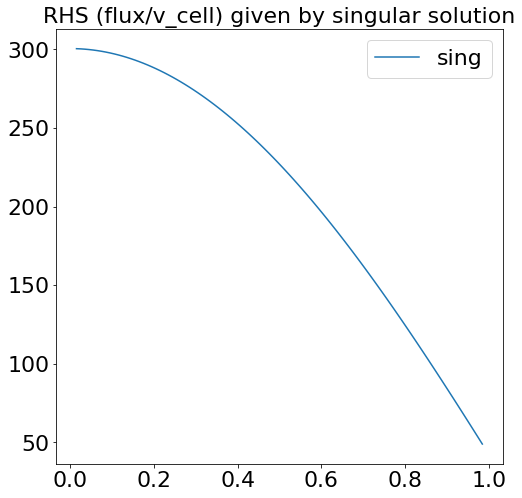

In [154]:
plt.figure()
plt.plot(f_s[1:-1], -RHS_real_fine[0,1:-1], label="real")
plt.plot(f_s[1:-1], -RHS_split_fine[0,1:-1], label="split")
plt.title("comparison of the right hand side at the first cell next to the vessel wall, \ni.e. computed flux entering from the vessel divided by cells volume", fontsize=22)
plt.legend()

plt.figure()
plt.plot(f_s[1:-1], -RHS_sing_fine[0,1:-1], label="sing")
plt.title("RHS (flux/v_cell) given by singular solution", fontsize=22)
plt.legend()

print("hs/V_cell={}".format(1/(np.pi*(f_hr+2*Rv)*f_hr)))

From now on the "coarse resolution starts". The discretization size is divided by a lot

14.67032761359149


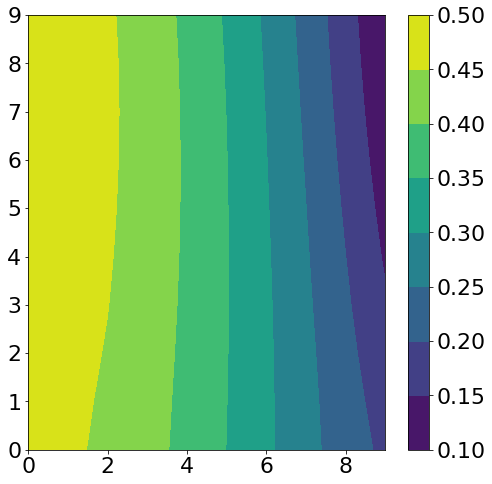

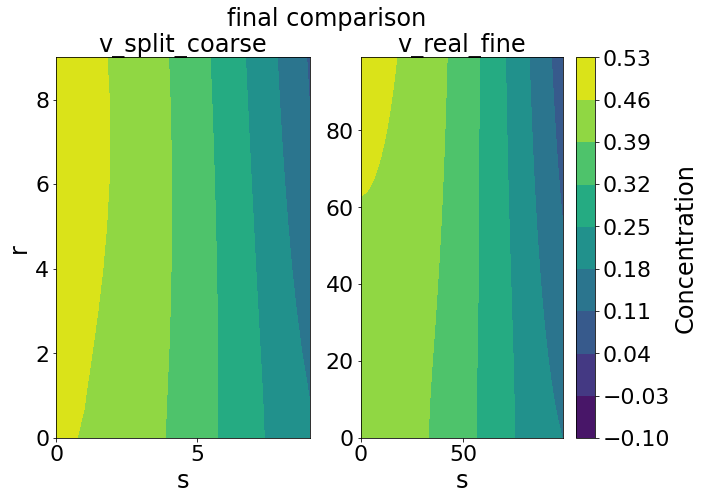

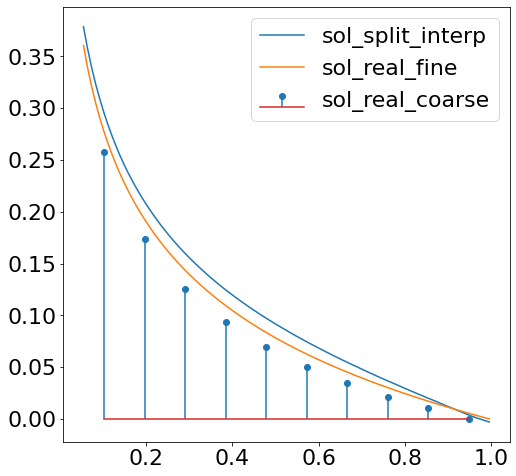

In [155]:
#Coarse_solution
coarse_r_points=10
coarse_s_points=10


#Let's create the Laplacian operator with the proper boundary conditions (Dirichlet north and 
#no flux east and west)
obj_coarse=simplified_assembly_Laplacian_cylindrical(R_max, Rv,coarse_r_points,coarse_s_points, L, D)
coarse_Lap=obj_coarse.assembly().toarray()

c_r=obj_coarse.r
c_s=obj_coarse.s
c_hs=obj_coarse.inc_s
c_hr=obj_coarse.inc_r

obj_RHS=get_coarse_RHS_v(obj_coarse, obj_fine, q_vessel, q_sec, q_first, coarse_Lap)


total_no_ghost=coarse_r_points*coarse_s_points
obj_RHS.seg_north_with_ghost()
RHS_split_coarse=obj_RHS.get_east_west_RHS()
RHS_split_coarse+=np.ndarray.flatten(obj_RHS.get_RHS_v())
RHSghost_split_coarse=obj_RHS.RHS_ghost
RHSghost_split_coarse[:total_no_ghost]=RHS_split_coarse

            
v_split_coarse=np.linalg.solve(obj_RHS.ghost_coarse_Lap,RHSghost_split_coarse)
vghost_split_coarse=v_split_coarse[:total_no_ghost]

f = interpolate.interp2d(obj_RHS.ghost_coarse.s,obj_RHS.ghost_coarse.r[:-1] , vghost_split_coarse.reshape(len(obj_RHS.ghost_coarse.r[:-1]), len(obj_RHS.ghost_coarse.s)), kind='linear')
vghost_split_interp=f(f_r, f_s)

plt.figure()
plt.contourf(vghost_split_coarse.reshape(len(c_r),len(c_s)))
plt.colorbar()

compare_full_solutions(v_split_coarse.reshape(len(c_r)+1,len(c_s))[:-1,:], v_real_fine, "v_split_coarse", "v_real_fine", [-0.1,0.6], "final comparison")


sol_split_interp=vghost_split_interp+sing_sing_fine



#Comparison of the coarse solution without coupling
kk=simplified_assembly_Laplacian_cylindrical(R_max, Rv,len(c_r),len(c_s), L, D)
hs, hr=kk.inc_s, kk.inc_r
Lap_operator=kk.assembly().toarray()
ext_boundary=np.concatenate([[kk.corners[2]], kk.outer_boundary, [kk.corners[3]]])
k_q_vessel=np.cos(kk.s/(L*0.7))
sol_real_coarse=get_RHS_validation(Lap_operator,k_q_vessel, Rv, kk.inc_r,kk.inc_s, D, ext_boundary)


plt.figure()
plt.plot(f_r, sol_split_interp[:,40], label="sol_split_interp")
plt.plot(f_r,sol_real_fine[:,40],label="sol_real_fine")
plt.stem(obj_RHS.coarse_r,sol_real_coarse[:,4],label="sol_real_coarse")
plt.legend()

In the last plot we cannot see the advantages of this scheme really. The resolution scheme (discrete laplacian operator) is always conservative. If the influx is impossed the resolution will always be quite good, especially in problems with symmetry like this one. 

The following code attempts in solve the same problem with a coupling to show how much better it performs

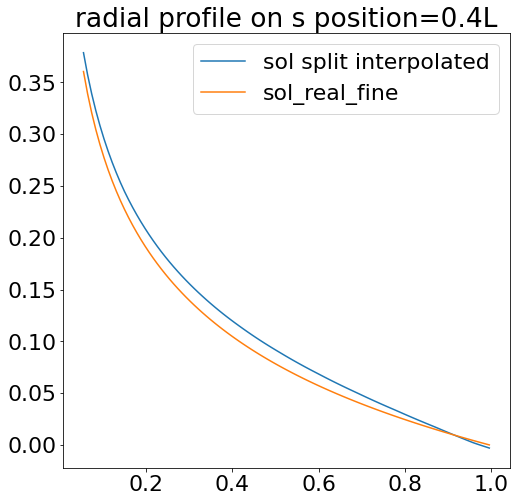

In [156]:
plt.plot(f_r, sol_split_interp[:,40], label="sol split interpolated")
plt.plot(f_r,sol_real_fine[:,40],label="sol_real_fine")
plt.title("radial profile on s position=0.4L")
plt.legend()

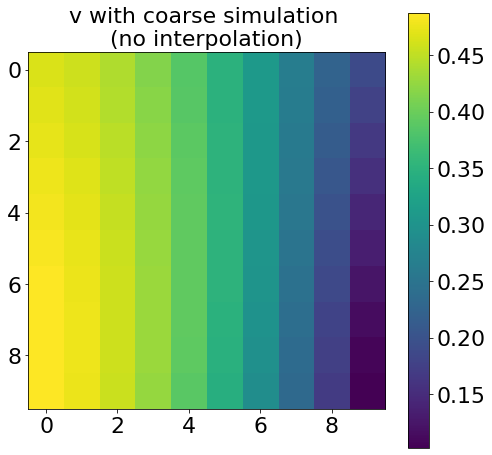

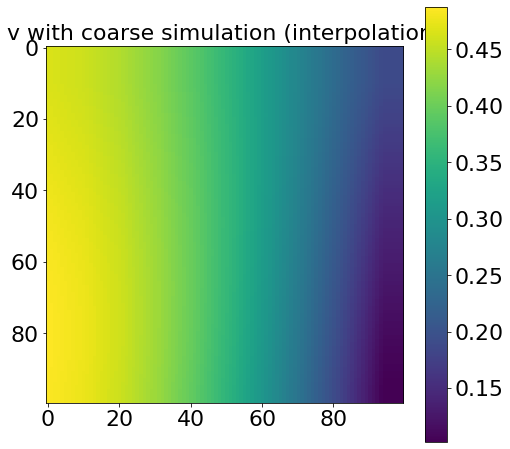

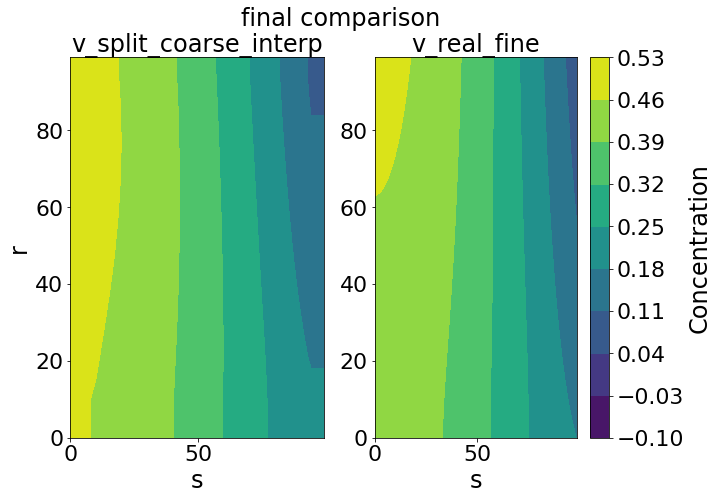

In [157]:
plt.figure()
plt.imshow(v_split_coarse[:total_no_ghost].reshape(coarse_r_points, coarse_s_points))
plt.colorbar()
plt.title("v with coarse simulation \n(no interpolation)", fontsize=22)


plt.figure()
plt.imshow(vghost_split_interp)
plt.colorbar()
plt.title("v with coarse simulation (interpolation)", fontsize=22)

compare_full_solutions(vghost_split_interp, v_real_fine, "v_split_coarse_interp", "v_real_fine", [-0.1,0.6], "final comparison")


[ 5 15 25 35 45 55 65 75 85 95]


Text(0.5, 0, 's')

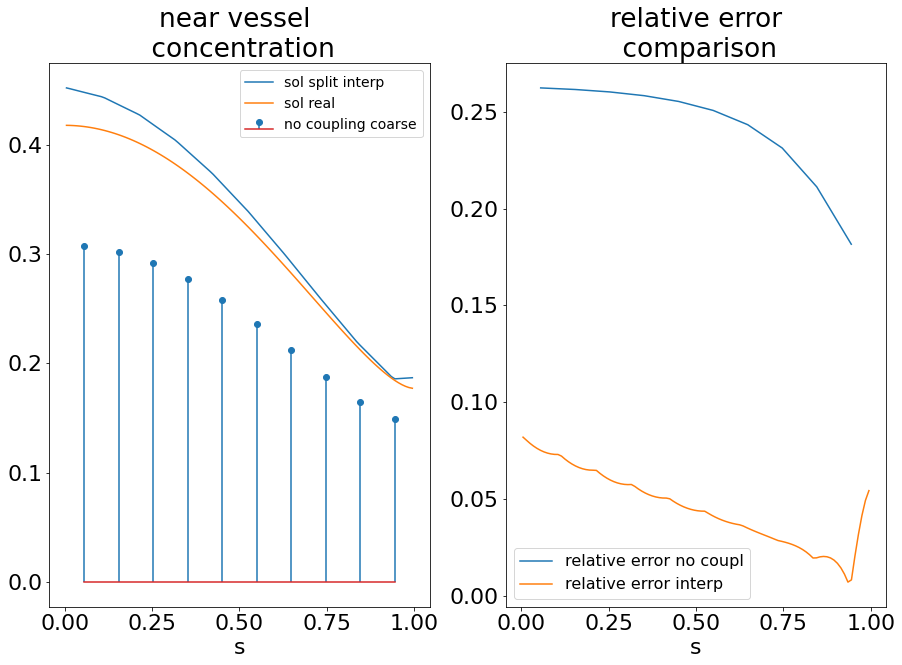

In [158]:
c_r=obj_RHS.coarse_r
c_s=obj_RHS.coarse_s
ratio=len(f_r)/len(c_r)

pos_coarse_fine=np.linspace(ratio/2, len(f_r)-ratio/2, len(c_r))
pos_coarse_fine=np.around(pos_coarse_fine).astype(int)
print(pos_coarse_fine)

fig, (ax1, ax2) = plt.subplots(1,2)




fig.set_size_inches(15, 10)

ax1.plot(f_s, sol_split_interp[0,:], label="sol split interp")
ax1.plot(f_s, sol_real_fine[0,:], label="sol real")
ax1.stem(c_s, sol_real_coarse[0,:], label="no coupling coarse")
ax1.legend(fontsize=14)
ax1.set_title("near vessel \n concentration")
ax1.set_xlabel("s")
ax2.plot(c_s,np.abs(sol_real_coarse[0,:]-sol_real_fine[0,pos_coarse_fine])/sol_real_fine[0,pos_coarse_fine],label="relative error no coupl")
ax2.plot(f_s, np.abs(sol_split_interp[0,:]-sol_real_fine[0,:])/sol_real_fine[0,:],label="relative error interp")
ax2.legend(fontsize=16)
ax2.set_title("relative error\n comparison")
ax2.set_xlabel("s")



In [159]:
np.linspace(0.26,1.68,5)

array([0.26 , 0.615, 0.97 , 1.325, 1.68 ])

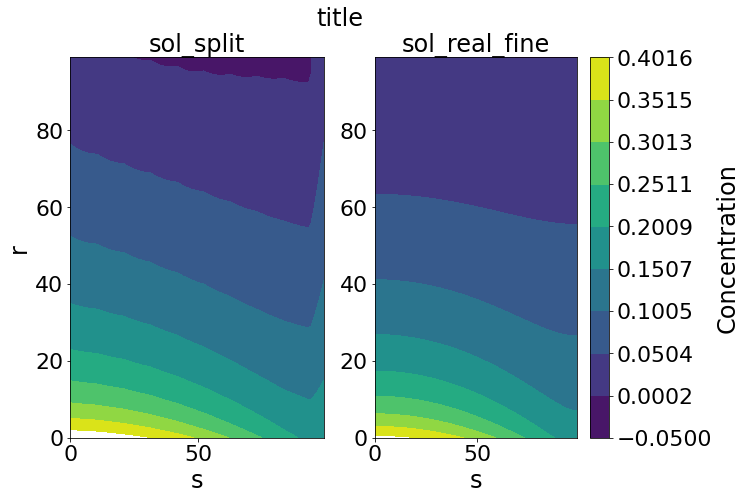

In [160]:
compare_full_solutions(sol_split_interp, sol_real_fine, "sol_split", "sol_real_fine", [-0.05,np.max(sol_split_interp)], "title")



In [161]:
np.min(sol_split_interp)

-0.004985144524287333

In [166]:
def coord_to_pos(x,coordx):
    a=np.argmin((x-coordx)**2)
    return(a)

#Coarse to fine adjacency matrix:
ff=np.zeros(len(f_r)*len(f_s)).astype(int)
for i in range(len(f_r)):
    for j in range(len(f_s)):
        pos=j*len(f_r)+i
        
        a_r=coord_to_pos(c_r,f_r[i])
        a_s=coord_to_pos(c_s,f_s[j])
        
        ff[pos]=a_r+a_s*len(c_s)
        
        
        

In [167]:
v_split_extended=np.zeros(len(f_r)*len(f_s))
for i in range(len(f_r)*len(f_s)):
    v_split_extended[i]=vghost_split_coarse[ff[i]]

In [178]:
sol_split_interp=vghost_split_interp+sing_sing_fine
sol_split_no_interp=v_split_extended.reshape([len(f_r), len(f_s)])+sing_sing_fine

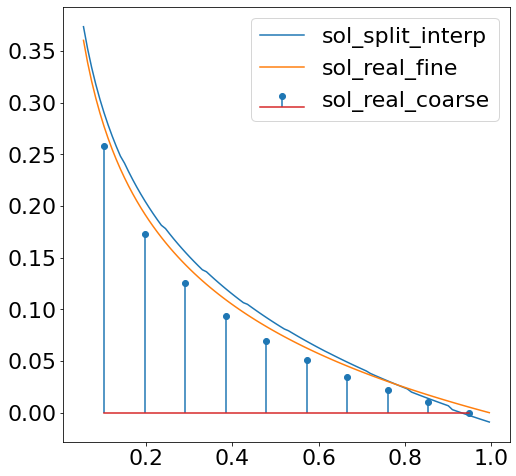

In [179]:
plt.figure()
plt.plot(f_r, sol_split_no_interp[:,40], label="sol_split_interp")
plt.plot(f_r,sol_real_fine[:,40],label="sol_real_fine")
plt.stem(obj_RHS.coarse_r,sol_real_coarse[:,4],label="sol_real_coarse")
plt.legend()

Text(0.5, 0, 's')

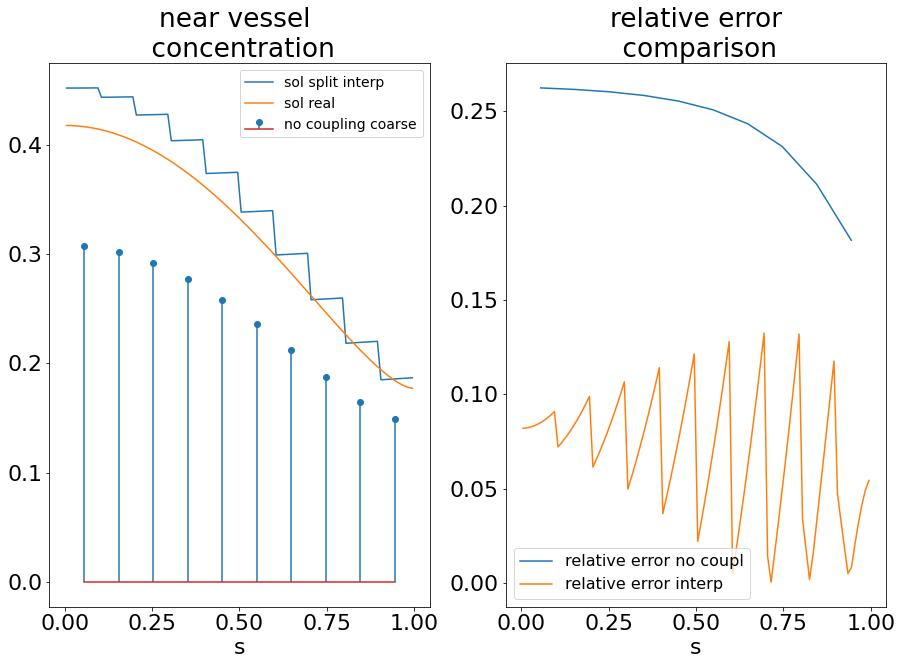

In [181]:
fig, (ax1, ax2) = plt.subplots(1,2)


fig.set_size_inches(15, 10)

ax1.plot(f_s, sol_split_no_interp[0,:], label="sol split interp")
ax1.plot(f_s, sol_real_fine[0,:], label="sol real")
ax1.stem(c_s, sol_real_coarse[0,:], label="no coupling coarse")
ax1.legend(fontsize=14)
ax1.set_title("near vessel \n concentration")
ax1.set_xlabel("s")
ax2.plot(c_s,np.abs(sol_real_coarse[0,:]-sol_real_fine[0,pos_coarse_fine])/sol_real_fine[0,pos_coarse_fine],label="relative error no coupl")
ax2.plot(f_s, np.abs(sol_split_no_interp[0,:]-sol_real_fine[0,:])/sol_real_fine[0,:],label="relative error interp")
ax2.legend(fontsize=16)
ax2.set_title("relative error\n comparison")
ax2.set_xlabel("s")